In [1]:
cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
from src.kinetic_model import KineticModel, modelSpace_to_modelParams, modelParams_to_modelSpace
from src.neural_network_builder import KineticEigenModelBuilder, KineticNeuralNetworkBuilder
from src.data import get_sim_deplete_data as get_data
from amber.architect import pmbga
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import yaml
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-7g63439k because the default path (/home/zzhang/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


detected tf2 - using compatibility mode


In [3]:
#model_params = yaml.load(open("./data/sim_data/22-05-12_cas9_kinn_deplete/ka_params.yaml"), Loader=yaml.Loader)
model_params = yaml.load(open("./data/sim_data/22-05-18_cas9_kinn_deplete_overlap/ka_params.yaml"), Loader=yaml.Loader)

data_fp = "data/sim_data/22-05-18_cas9_kinn_deplete_overlap/cas9_kinn_deplete_full_data.tsv"
model_params = modelParams_to_modelSpace(model_params)
logbase = 10
kinn = KineticModel(model_params)
(x_train, y_train), (x_test, y_test) = get_data(
    fp=data_fp,
    logbase=logbase)

(5000, 12)
(4613, 12)
0.9800041666377762 0.9998365927637564


In [4]:
if logbase is None:
    output_op = lambda: tf.keras.layers.Lambda(lambda x: x, name="output_nominal")
else:
    output_op= lambda: tf.keras.layers.Lambda(lambda x: tf.math.log(x)/np.log(logbase), name="output_log")
    
mb = KineticNeuralNetworkBuilder(
        kinn=kinn,
        output_op=output_op,
        n_channels=9,
        n_feats=50,
        replace_conv_by_fc=False)

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10*int(7000/128), # decrease every 10 epochs
    decay_rate=0.9,
    staircase=True)
mb.build(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
x_train_b = mb.blockify_seq_ohe(x_train)
x_test_b = mb.blockify_seq_ohe(x_test)


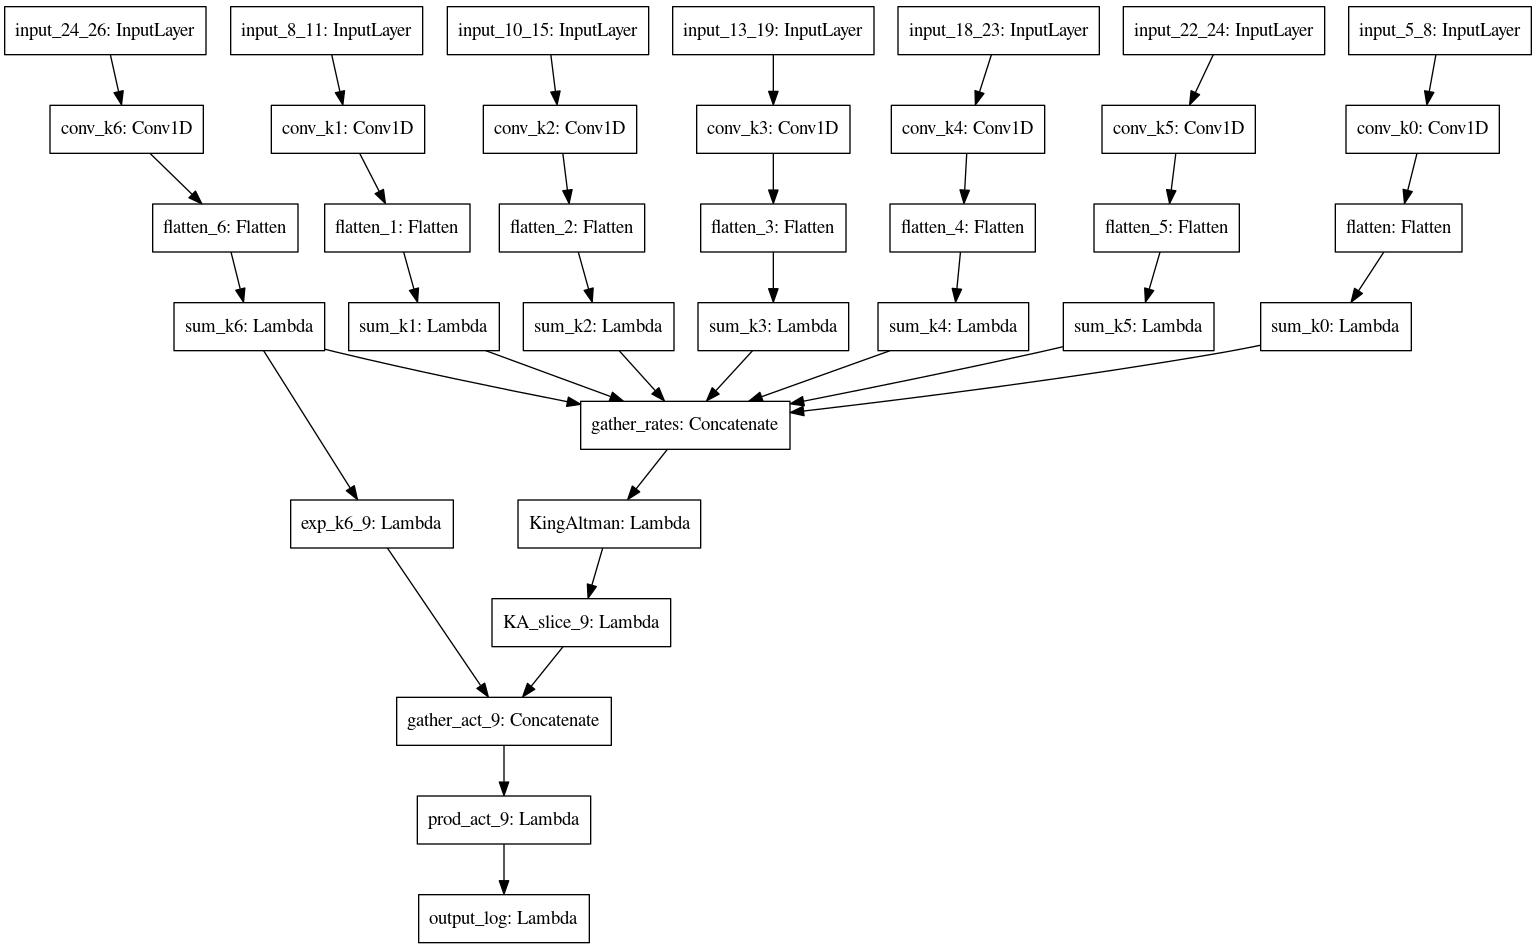

In [5]:
model = mb.model
tf.keras.utils.plot_model(model)

In [6]:
set_weights = True
# if set weights, plug in the ground truth parameter values
if set_weights:
    layer_dict = {l.name:l for l in model.layers}
    for k in range(7):
        bp_rate = model_params['Rates'][k]
        ml_rate = layer_dict['conv_k%i'%k]
        bp_rate_bias = np.array(bp_rate['base_rate']).reshape((1,))
        bp_rate_bias = np.log(bp_rate_bias)
        bp_rate_bias /= (bp_rate['input_range'][1] - bp_rate['input_range'][0])
        bp_rate_mm = - float(bp_rate['weight_distr'].split()[-1].rstrip('])'))
        bp_rate_pwm = np.array([bp_rate_mm] * 4 + [0]*5).reshape((1,9,1))
        print(k, bp_rate_mm, bp_rate_bias)
        ml_rate.set_weights([bp_rate_pwm, bp_rate_bias])

# otherwise, train parameters with data
else:
    checkpointer = ModelCheckpoint(filepath="bestmodel.h5", mode='min', verbose=0, save_best_only=True,
                           save_weights_only=True)
    earlystopper = EarlyStopping(
        monitor="val_loss",
        mode='min',
        patience=5,
        verbose=0)

    hist = model.fit(x_train_b, y_train,
              batch_size=128,
              validation_data=(x_test_b, y_test),
              callbacks=[checkpointer, earlystopper],
              epochs=3000, verbose=0)
    model.load_weights("bestmodel.h5")


0 -5.0 [-1.76610579]
1 2.5 [-1.53505673]
2 -3.0 [-0.32188758]
3 2.5 [-0.65200383]
4 -3.5 [0.32188758]
5 1.5 [-2.9045715]
6 -0.5 [0.]


In [7]:
y_hat = model.predict(x_test_b).flatten()
if logbase is None:
    test_reward = ss.pearsonr(y_hat, y_test)[0]
else:
    test_reward = ss.pearsonr(logbase**y_hat, logbase**y_test)[0]
print(test_reward)

0.9952708673045924


/mnt/home/zzhang/anaconda3/envs/tf24/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Text(0.5, 1.0, 'Pred Eigval vs Fit\npcc=0.995')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


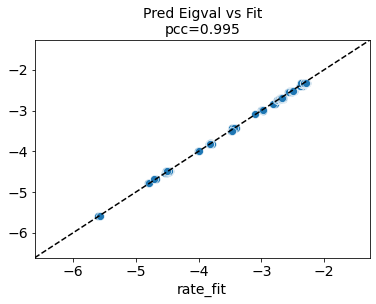

In [8]:
%matplotlib inline
ax = sns.scatterplot(x=y_test, y=y_hat)
vmin, vmax = min(y_hat.min(), y_test.min()), max(y_hat.max(), y_test.max()), 
ax.set_xlim(vmin-1, vmax+1)
ax.set_ylim(vmin-1, vmax+1)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', color='black')
ax.set_title('Pred Eigval vs Fit\npcc=%.3f' % test_reward)

In [9]:
df = pd.read_table(data_fp)
df.loc[(y_test - y_hat).abs().sort_values(ascending=False).index].head()

,seq,k_{uo},k_{ou},k_{oi},k_{io},k_{ic},k_{ci},k_{cut},first_eigval,rate_fit,rate_fit_sem,rate_fit_rsqr
963,TCGGTAGGATCGTAAGGTACTATTCAGGACCCCGTTAACCATTTCG...,0.005,0.01,0.200000,0.243650,0.150987,0.003,1.0,-0.004380,0.004679,0.000139,0.998193
85,TCGGTAGGATCGTAAGGTAGTATTCAGGACCCCGTTAACCATTTCG...,0.005,0.01,0.200000,0.243650,5.000000,0.003,1.0,-0.004745,0.005309,0.000115,0.999280
1404,TCGGTAGGATCGTTAGATAGTATTCAGGACCCTGTTAACCATTTCG...,0.005,0.01,0.009957,0.243650,5.000000,0.003,1.0,-0.002122,0.002204,0.000176,0.997666
2492,TCGGTAGGATCGTAGCATAGTATTCAGGACCCCGTTAACCATTTCG...,0.005,0.01,0.009957,2.968263,5.000000,0.003,1.0,-0.001588,0.001671,0.000152,0.997750
3340,TCGGTAGGATCGTAAGATAGTTTTCAGGACCCCGTTAACCATTTCG...,0.005,0.01,0.200000,0.020000,0.150987,0.003,1.0,-0.004724,0.005042,0.000166,0.998478


Text(0.5, 1.0, 'Obs Eigval vs Fit\npcc=0.999')

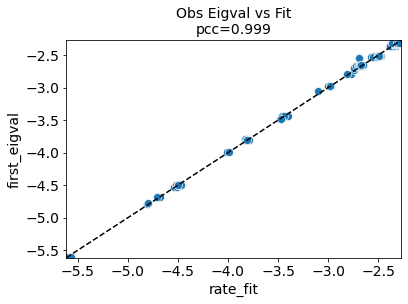

In [10]:
y_eig = - df.loc[y_test.index]['first_eigval']
if logbase is not None:
    y_eig = np.log(y_eig) / np.log(logbase)
ax = sns.scatterplot(x=y_test, y=y_eig)
vmin, vmax = min(y_eig.min(), y_test.min()), max(y_eig.max(), y_test.max()), 
ax.set_xlim(vmin-0.001, vmax+0.001)
ax.set_ylim(vmin-0.001, vmax+0.001)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', color='black')
ax.set_title('Obs Eigval vs Fit\npcc=%.3f' % ss.pearsonr(y_eig, y_test)[0])

In [11]:
rate_mod = tf.keras.models.Model(inputs=mb.model.inputs, outputs=mb.layer_dict['gather_rates'].output)
pred_rates = rate_mod.predict(mb.blockify_seq_ohe(x_test))
test_df = df.loc[y_test.index]
test_df[['k_%i'%i for i in range(pred_rates.shape[1])]] = np.exp(pred_rates)

/mnt/home/zzhang/anaconda3/envs/tf24/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [12]:
name_to_index = {
        'k_{uo}': [((0,0), -1), ((1,0),  1), ],
        'k_{ou}': [((0,1),  1), ((1,1), -1), ],
        'k_{oi}': [((1,1), -1), ((2,1),  1), ],
        'k_{io}': [((1,2),  1), ((2,2), -1), ],
        'k_{ic}': [((2,2), -1), ((3,2),  1), ],
        'k_{ci}': [((2,3),  1), ((3,3), -1), ],
        'k_{cut}':[((3,3), -1), ((4,3),  1), ],
        # for pred
        'k_0': [((0,0), -1), ((1,0),  1), ],
        'k_1': [((0,1),  1), ((1,1), -1), ],
        'k_2': [((1,1), -1), ((2,1),  1), ],
        'k_3': [((1,2),  1), ((2,2), -1), ],
        'k_4': [((2,2), -1), ((3,2),  1), ],
        'k_5': [((2,3),  1), ((3,3), -1), ],
        'k_6': [((3,3), -1), ((4,3),  1), ]

}

def make_kinetic_matrix(vec):
    mat = np.zeros((5,5))
    for name, value in vec.items():
        if not name in name_to_index: continue
        for idx, sign in name_to_index[name]:
            mat[idx] += value * sign
    return mat


def get_first_eigval(vec):
    mat = make_kinetic_matrix(vec)
    eigvals, eigvecs = np.linalg.eig(mat)
    lam_1 = sorted(eigvals, reverse=True)[1]
    return lam_1

#print(np.round([get_first_eigval(r[8:]) for _,r in test_df.iterrows()], 5))
test_df['pred_rate_eigval'] = [get_first_eigval(r[8:]) for _,r in test_df.iterrows()]

In [13]:
test_df.head()

,seq,k_{uo},k_{ou},k_{oi},k_{io},k_{ic},k_{ci},k_{cut},first_eigval,rate_fit,rate_fit_sem,rate_fit_rsqr,k_0,k_1,k_2,k_3,k_4,k_5,k_6,pred_rate_eigval
963,TCGGTAGGATCGTAAGGTACTATTCAGGACCCCGTTAACCATTTCG...,0.005,0.010000,0.200000,0.24365,0.150987,0.003000,1.0,-0.004380,0.004679,0.000139,0.998193,0.005,0.010000,0.200000,0.24365,0.150987,0.003000,1.0,-0.004380
4380,TCGGTAGGATCGCAAGATATTATTCAGGACCCCGTTAACCATTTCG...,0.005,0.010000,0.009957,0.02000,0.150987,0.003000,1.0,-0.002017,0.001862,0.000151,0.998093,0.005,0.010000,0.009957,0.02000,0.150987,0.003000,1.0,-0.002017
756,TCGGTAGGATCGTAAGATAGTATTCAGCACCCCGTTAACCATTTCG...,0.005,0.010000,0.200000,0.02000,5.000000,0.003000,1.0,-0.004755,0.004726,0.000162,0.998587,0.005,0.010000,0.200000,0.02000,5.000000,0.003000,1.0,-0.004755
2808,TCGGTAGGATCGTATGATAGTATACAGGACCCCGTTAACCATTTCG...,0.005,0.010000,0.009957,0.24365,5.000000,0.013445,1.0,-0.002121,0.002145,0.000198,0.996935,0.005,0.010000,0.009957,0.24365,5.000000,0.013445,1.0,-0.002121
585,TCGGTAGGATAGTAAGATAGTATTCAGGACCCCGTTATCCATTTCG...,0.005,0.121825,0.009957,0.02000,5.000000,0.003000,1.0,-0.000364,0.000349,0.000026,0.999731,0.005,0.121825,0.009957,0.02000,5.000000,0.003000,1.0,-0.000364


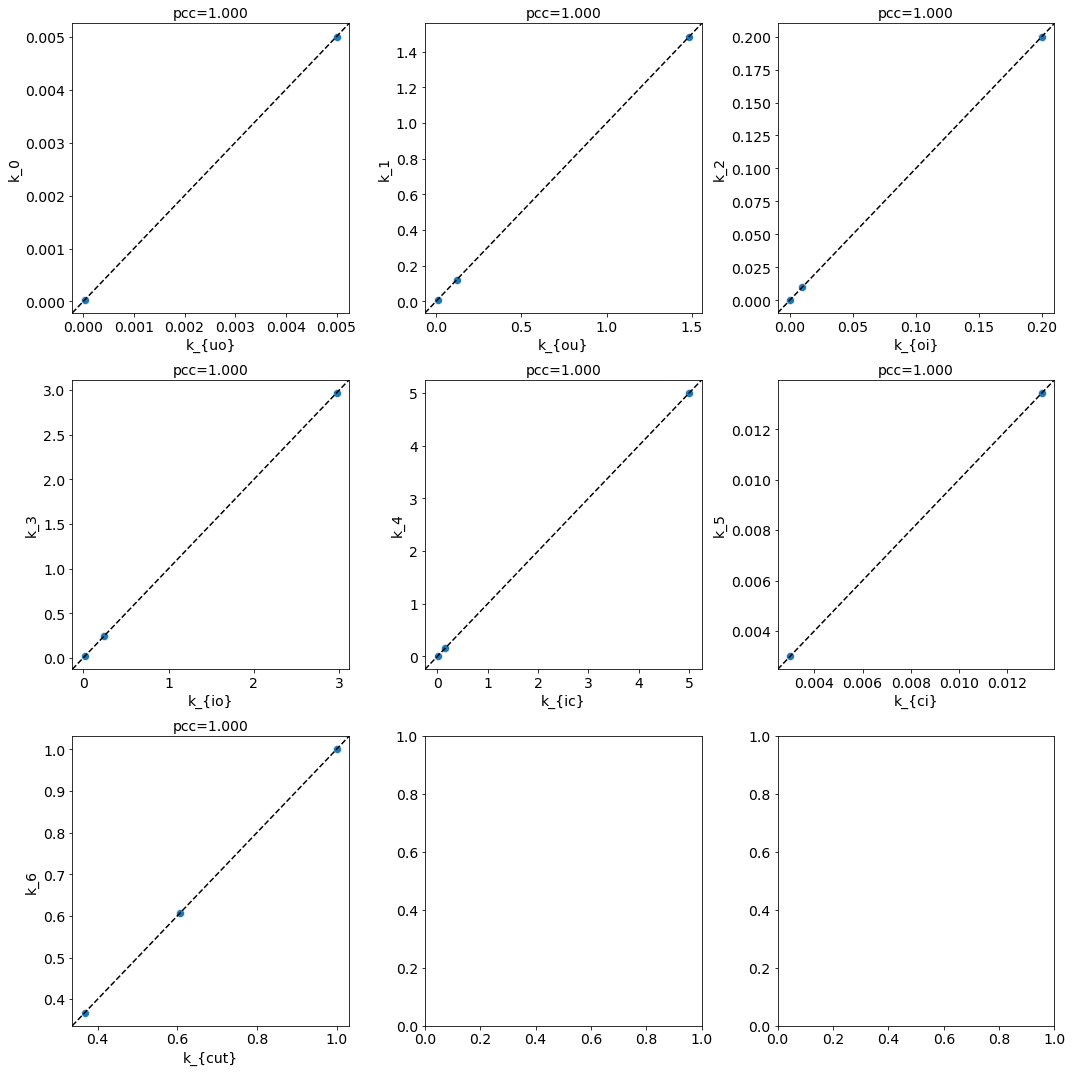

In [14]:
# the rates are not aligned to ground-truth
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for i in range(7):
    ax = sns.scatterplot(x=test_df.iloc[:, 1+i], y=test_df.iloc[:, 12+i], ax=axs[i])
    val_max = min(test_df.iloc[:, 1+i].max(), test_df.iloc[:, 12+i].max())
    #ax.set_xlim(0,val_max)
    #ax.set_ylim(0,val_max)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', color='black')
    ax.set_title("pcc=%.3f"%ss.pearsonr(test_df.iloc[:, 1+i], test_df.iloc[:, 12+i])[0])
fig.tight_layout()

Text(0.5, 1.0, 'pcc=1.000')

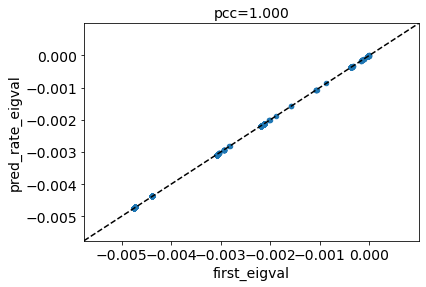

In [15]:
# but the kinetic matrix's eigenvalue are aligned
ax = test_df.plot.scatter(x='first_eigval', y='pred_rate_eigval')
vmin, vmax = min(test_df['first_eigval'].min(), test_df['pred_rate_eigval'].min()), max(test_df['first_eigval'].max(), test_df['pred_rate_eigval'].max()), 
ax.set_xlim(vmin-0.001, vmax+0.001)
ax.set_ylim(vmin-0.001, vmax+0.001)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls='--', color='black')
ax.set_title("pcc=%.3f"%ss.pearsonr(test_df['first_eigval'], test_df['pred_rate_eigval'])[0])

In [16]:
layer_id = "conv_k0"
print(np.around(mb.layer_dict[layer_id].get_weights()[0],3))
print(np.around(mb.layer_dict[layer_id].get_weights()[1],3))

[[[-5.]
  [-5.]
  [-5.]
  [-5.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]]]
[-1.766]


In [17]:
layer_id = "conv_k1"
print(np.around(mb.layer_dict[layer_id].get_weights()[0],3))
print(np.around(mb.layer_dict[layer_id].get_weights()[1],3))

[[[2.5]
  [2.5]
  [2.5]
  [2.5]
  [0. ]
  [0. ]
  [0. ]
  [0. ]
  [0. ]]]
[-1.535]


In [18]:
layer_id = "conv_k2"
print(np.around(mb.layer_dict[layer_id].get_weights()[0],3))
print(np.around(mb.layer_dict[layer_id].get_weights()[1],3))

[[[-3.]
  [-3.]
  [-3.]
  [-3.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]
  [ 0.]]]
[-0.322]


In [19]:
layer_id = "conv_k3"
print(np.around(mb.layer_dict[layer_id].get_weights()[0],3))
print(np.around(mb.layer_dict[layer_id].get_weights()[1],3))

[[[2.5]
  [2.5]
  [2.5]
  [2.5]
  [0. ]
  [0. ]
  [0. ]
  [0. ]
  [0. ]]]
[-0.652]


In [20]:
layer_id = "conv_k4"
print(np.around(mb.layer_dict[layer_id].get_weights()[0],3))
print(np.around(mb.layer_dict[layer_id].get_weights()[1],3))

[[[-3.5]
  [-3.5]
  [-3.5]
  [-3.5]
  [ 0. ]
  [ 0. ]
  [ 0. ]
  [ 0. ]
  [ 0. ]]]
[0.322]


In [21]:
layer_id = "conv_k5"
print(np.around(mb.layer_dict[layer_id].get_weights()[0],3))
print(np.around(mb.layer_dict[layer_id].get_weights()[1],3))

[[[1.5]
  [1.5]
  [1.5]
  [1.5]
  [0. ]
  [0. ]
  [0. ]
  [0. ]
  [0. ]]]
[-2.905]


In [22]:
layer_id = "conv_k6"
print(np.around(mb.layer_dict[layer_id].get_weights()[0],3))
print(np.around(mb.layer_dict[layer_id].get_weights()[1],3))

[[[-0.5]
  [-0.5]
  [-0.5]
  [-0.5]
  [ 0. ]
  [ 0. ]
  [ 0. ]
  [ 0. ]
  [ 0. ]]]
[0.]
